In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
plt.style.use('seaborn')

## Response time 
How long does the average user wait? That data is recorded in the responses and we can plot a histogram. 

In [2]:
def time_hist(times, log=True, bins=50, limit_max=3, limit_min=0,
              xlabel='Network delay (s)'):
    times = np.sort(times)
    i = np.argwhere((limit_min < times) & (times < limit_max))

    _ = plt.hist(times[i], bins=bins, log=log)
    plt.xlim(limit_min, limit_max)
    plt.xlabel(xlabel)

771049 total responses


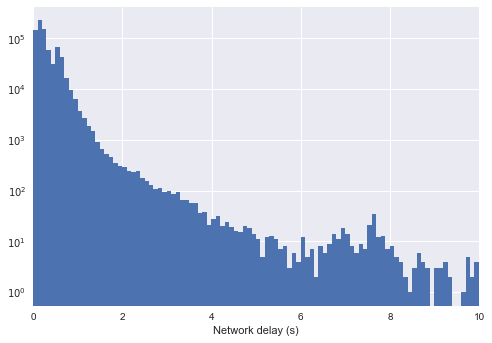

In [3]:
fig = plt.figure()
responses = utils.read_responses('557-responses.csv.zip')
print('{} total responses'.format(len(responses)))
time_hist(np.abs(responses['network_delay'].values), log=True, bins=100, limit_max=10)
plt.show()

## Server delay
We have seen that *at times of low activity* some users see a delay of approximately 2 seconds getting a query. This happens infrequently, about a total of 700 times in about 700k responses (or 0.1% of the visits to NEXT).

We hypothesize that this is due to some database connection or similar getting dropped in times of low activity. The spikes have a low variance and are almost exactly 2 seconds. The makes sense if it takes about 2 seconds to restore the connection (which could be to the database, with celery, etc).

In [4]:
responses = responses.sort_values(by='timestamp_query_generated')
responses['time_since_last_visitor'] = responses['timestamp_query_generated'].diff()
responses['time_since_last_visitor'] = [float(d.total_seconds()) if i > 0 else 0
                                 for i, d in enumerate(responses['time_since_last_visitor'])]
responses.head()

,alg_label,network_delay,participant_uid,response_time,target,target_id,target_reward,timestamp_query_generated,time_since_last_visitor
300143,LilUCB,0.352758,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,6.785,"Ah, you cooked my goose!",7990,1.0,2017-02-21 00:39:15.599235,0.000000
300144,LilUCB,0.197962,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,3.324,Four and twenty blackbirds or eternal temptation?,7049,1.0,2017-02-21 00:39:22.953877,7.354642
300145,LilUCB,0.125092,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.797,"But dearest, half-baked knowledge is not the s...",5664,1.0,2017-02-21 00:39:26.657089,3.703212
300146,LilUCB,0.180176,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.626,"I mean, I really feel like it does have gluten.",5603,3.0,2017-02-21 00:39:28.732162,2.075073
300147,LilUCB,0.322353,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.360,Have some apple pie.,2499,3.0,2017-02-21 00:39:30.720991,1.988829


In [5]:
since = responses['time_since_last_visitor']
since = since[since < 60*60]  # 1 hour

bins = 1000
n_time_since, times_since = np.histogram(since, bins=bins)

data = {'n_users': [0] + list(n_time_since),
        'time_since_last_visitor': list(times_since),
        'delays': np.zeros((len(times_since), 0)).tolist()}

In [6]:
for _, response in responses.iterrows():
    i = times_since - response['time_since_last_visitor'] >= 0
    if len(times_since[i]) > 0 and 0 <= response['network_delay'] < 10:
        wait = times_since[i][0]
        wait_i = np.argwhere(times_since == wait).flat[:][0]
        data['delays'][wait_i] += [response['network_delay']]

In [7]:
df = pd.DataFrame(data)
df.head()

,delays,n_users,time_since_last_visitor
0,[0.3527579141693113],0,0.000000
1,"[0.18017607247924805, 0.3223531049041748, 0.26...",737744,2.313369
2,"[0.12509206866455092, 0.20516299427795426, 0.1...",24388,4.626737
3,"[0.11853696948242187, 0.20065903623962456, 0.2...",4894,6.940106
4,"[0.1979618798370364, 0.20401197711181676, 0.21...",1879,9.253475


In [9]:
avg_delay = [np.mean(row['delays']) if len(row['delays']) > 0 else np.nan
              for _, row in df.iterrows()]
max_delay = [np.max(row['delays']) if len(row['delays']) > 0 else np.nan
              for _, row in df.iterrows()]
df['avg_delay'] = avg_delay
df['max_delay'] = max_delay
df.drop('delays', axis=1, inplace=True)
df.head()

,n_users,time_since_last_visitor,avg_delay,max_delay
0,0,0.000000,0.352758,0.352758
1,737744,2.313369,0.287261,9.988721
2,24388,4.626737,0.556962,8.567334
3,4894,6.940106,0.592825,7.629698
4,1879,9.253475,0.612269,3.285116


In [10]:
df.iloc[:5]

,n_users,time_since_last_visitor,avg_delay,max_delay
0,0,0.000000,0.352758,0.352758
1,737744,2.313369,0.287261,9.988721
2,24388,4.626737,0.556962,8.567334
3,4894,6.940106,0.592825,7.629698
4,1879,9.253475,0.612269,3.285116


In [11]:
from altair import Chart, Y, Scale
c1 = Chart(df).mark_bar().encode(
    x='time_since_last_visitor', y=Y('n_users', scale=Scale(type='linear', domain=(0, 10), clamp=True)))

In [19]:
c2 = Chart(df).mark_circle(color='#ff7f0e').encode(
    x='time_since_last_visitor', y='avg_delay')
c3 = Chart(df).mark_circle(color='#ff7f0e').encode(
    x='time_since_last_visitor', y='max_delay')

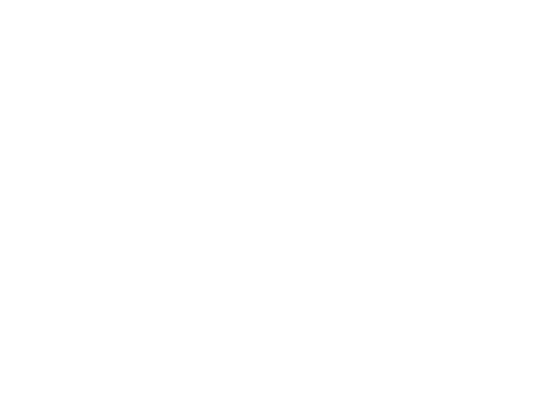

In [20]:
chart = c1 + c2
chart.data = df
chart

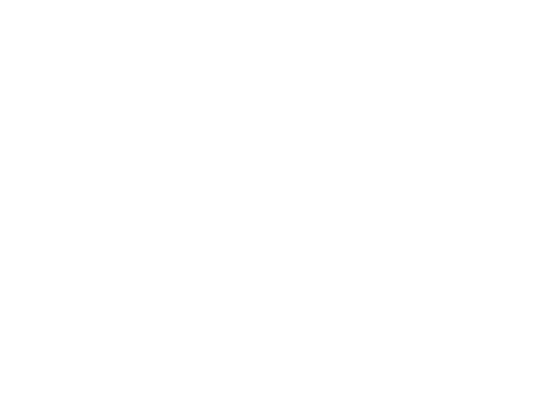

In [21]:
chart = c1 + c3
chart.data = df
chart

It looks like theres a delay at around 1000 seconds, or about 15 minutes. But it's not clear in this graph.

## Using time


In [22]:
responses = utils.read_responses('557-responses.csv.zip')
responses = responses.sort_values(by='timestamp_query_generated')
responses['time_since_last_visitor'] = responses['timestamp_query_generated'].diff()
responses['time_since_last_visitor'] = [float(d.total_seconds()) if i > 0 else 0
                                 for i, d in enumerate(responses['time_since_last_visitor'])]

start = responses['timestamp_query_generated'].min()
time = responses['timestamp_query_generated'].apply(lambda x: (x - start).total_seconds())
responses['time_query_generated'] = time
responses.head()

,alg_label,network_delay,participant_uid,response_time,target,target_id,target_reward,timestamp_query_generated,time_since_last_visitor,time_query_generated
300143,LilUCB,0.352758,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,6.785,"Ah, you cooked my goose!",7990,1.0,2017-02-21 00:39:15.599235,0.000000,0.000000
300144,LilUCB,0.197962,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,3.324,Four and twenty blackbirds or eternal temptation?,7049,1.0,2017-02-21 00:39:22.953877,7.354642,7.354642
300145,LilUCB,0.125092,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.797,"But dearest, half-baked knowledge is not the s...",5664,1.0,2017-02-21 00:39:26.657089,3.703212,11.057854
300146,LilUCB,0.180176,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.626,"I mean, I really feel like it does have gluten.",5603,3.0,2017-02-21 00:39:28.732162,2.075073,13.132927
300147,LilUCB,0.322353,b8b6dfe6a76d4243ba28e18ec9a7d3_i2LRqGUfVpXHmCC...,1.360,Have some apple pie.,2499,3.0,2017-02-21 00:39:30.720991,1.988829,15.121756


In [23]:
responses['time_since_last_visitor'].max()

12132.861920000001

In [24]:
delay = responses['network_delay'].values
np.unique(delay)
delay = np.clip(delay, 0, 100)
np.unique(delay)
responses['network_delay_trimmed'] = delay

array([ -1.72796870e+05,  -8.63990395e+04,  -8.63989932e+04, ...,
         6.62536930e+01,   7.60629991e+01,   6.88462312e+02])

array([  0.00000000e+00,   6.04898911e-04,   1.66288365e-03, ...,
         6.62536930e+01,   7.60629991e+01,   1.00000000e+02])

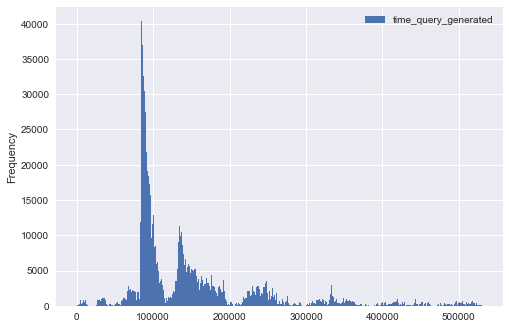

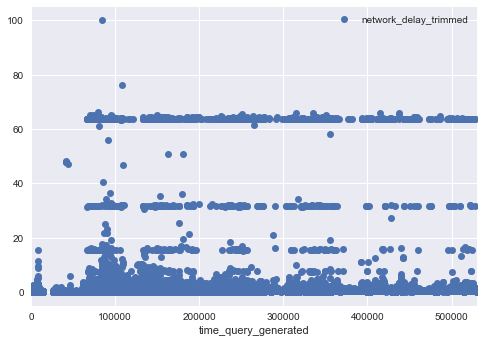

In [25]:
responses.plot(kind='hist', y='time_query_generated', logy=False, bins=400)
responses.plot(x='time_query_generated', y='network_delay_trimmed', style='o')
plt.show()

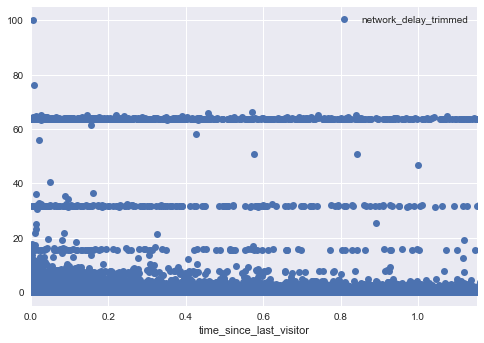

In [26]:
responses.plot(x='time_since_last_visitor', y='network_delay_trimmed', style='o')
plt.show()

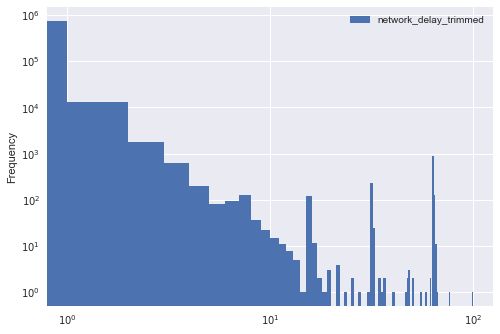

In [27]:
responses.plot(kind='hist', y='network_delay_trimmed', bins=100, logy=True, logx=True)

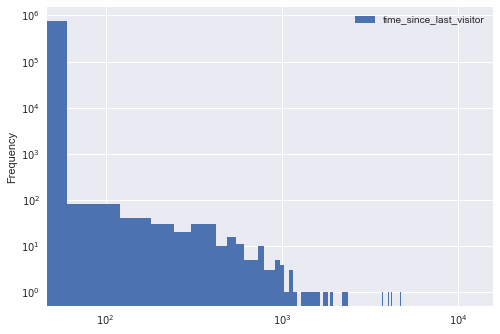

In [28]:
responses.plot(kind='hist', y='time_since_last_visitor', bins=200, logy=True, logx=True)

In [29]:
np.sort(responses['time_since_last_visitor'].values)

array([  0.00000000e+00,   1.00000000e-06,   1.00000000e-06, ...,
         4.16991625e+03,   4.68416393e+03,   1.21328619e+04])